# Lyrics-Based Music Genre Classifier

## A comparison of Large Language Models to other Machine Learning techniques

The goal of this project is to see if machine learning models can be used to identify a song's genre based solely on its lyrics.

In addition to traditional machine learning models trained on TF-IDF features, a lightweight Large Language Model (LLM) was evaluated for zero-shot genre classification. Unlike API-based models, this approach runs locally in Google Colab and leverages GPU acceleration to avoid rate limits and improve inference speed.

**FLAN-T5-base**, was used as an instruction-tuned encoder–decoder model, and frame genre prediction as a text-to-text task using prompt-based classification.

## **Ethical and Copyright Considerations**


This project uses song lyrics solely for non-commercial, educational analysis.
Lyrics are not redistributed, published, or regenerated by any model.

All models operate on transformed representations of the text (e.g., TF-IDF features or summarized descriptions), and outputs are limited to genre labels.

All large language models in this project were executed locally using
pretrained weights. No fine-tuning or gradient updates were performed,
and no input data was transmitted to third-party APIs or external servers.
As a result, copyrighted song lyrics were not retained, logged, or reused
for future model training. This local inference approach ensures that all
analysis remains isolated to the project environment and does not
contribute to the training of downstream models.

Such use is transformative and consistent with fair use principles under U.S. copyright law (Authors Guild v. Google, Inc., 804 F.3d 202 (2d Cir. 2015); Authors Guild v. HathiTrust, 755 F.3d 87 (2d Cir. 2014)).

Courts have held that full-text ingestion for the purpose of indexing, classification, and non-expressive analysis does not constitute copyright infringement when it does not substitute for the original work.


## The First Hurdle

While looking through possible APIs to simplify this process, it was discovered that Genius no longer allows lyrics to be obtained via its API. Musixmatch, another large online repository for music lyrics —and the one used by many music streaming services for their lyrics scrolls— doesn't allow the storage of lyrics or the training of models according to their terms of service.

This meant neither service could be used.

Much of the initial set up of the project was spent finding the best ways to carry out the analysis without infringing on copyright laws.

The following methods were used to avoid any violations of terms of service or issues with legality:

*   Lyrics were taken by hand from google results. No web scraping or other automated methods were used.
*   Models were run locally to prevent the lyrics or results from flowing downstream to be used by others.
*   No lyrics are saved into the project nor displayed in the final output.
*   The file stored publically does not contain the lyrics, only the song, artist, and chart the song was pulled from.
*   The lyrics are neither aggregated nor reused in anyway.
*   None of results are intended for commercial use.
*   All methods used are open source and pre-tuned to prevent



## Environment Setup

This Colab builds a dataset from songs.csv, enriches it with Last.fm genre tags, then trains a baseline model and evaluates an LLM classifier.

In [1]:
# End-to-End Lyrics Genre Classification (Last.fm)

!pip install -q pandas numpy scikit-learn matplotlib seaborn tqdm pylast transformers sentencepiece torch requests


import os, json, time, re, requests, pylast, torch, re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from google.colab import userdata
from transformers import pipeline

LASTFM_KEY = userdata.get('LASTFM_KEY')

print(LASTFM_KEY is not None)

network = pylast.LastFMNetwork(
    api_key=LASTFM_KEY,
    api_secret="ignore"
)




True


In order to ensure speedy, and accurate analyis, the Colab needs to be set to use a Graphics Processing Unit (GPU) for all model training and analysis.

In [2]:
device = 0 if torch.cuda.is_available() else -1
print("Using device:", device)

!nvidia-smi

Using device: 0
Sun Feb  1 18:19:30 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------

Because Billboard does not have a publically facing API, a spreadsheet was used to collect chart data for the following charts by manually inserting the records. This avoided any issues with Terms of Service for Billboard or their affiliates.
   
*   Spotify Weekly Top Songs USA
*   Billboard Country
*   Billboard Rock
*   Billboard Latin
*   Billboard Dance

**For ease of reference, features and multi artist releases were condensed to the primary artist.**

**Duplicate entries were also removed**

In [3]:
df = pd.read_csv("/content/songs.csv")

print("Rows:", len(df))
print("With lyrics:", df["lyrics"].notna().sum())
df.head()


# LAST.FM TAGS:


def get_lastfm_tags(artist, track):
    try:
        t = network.get_track(artist, track)
        tags = [tag.item.name.lower() for tag in t.get_top_tags()[:5]]
        if tags:
            return tags
    except:
        pass

    # Fallback: use artist tags
    try:
        a = network.get_artist(artist)
        return [tag.item.name.lower() for tag in a.get_top_tags()[:5]]
    except:
        return []

tqdm.pandas()
df["tags"] = df.progress_apply(lambda x: get_lastfm_tags(x["artist"], x["song_title"]), axis=1)

print("With Last.fm tags:", df["tags"].apply(len).gt(0).sum())


Rows: 356
With lyrics: 356


100%|██████████| 356/356 [03:29<00:00,  1.70it/s]

With Last.fm tags: 347


## Mapping Songs To Target Genres

Now that a list of songs, their lyrics, and a list of genres were collected, each song was mapped to one of seven (7) larger genres based on the sub-genres they might be tagged to.

The nature of the list means that songs that are part of many hybrid sub-genres might be classified as a genre higher in the hierarchy.

This meant the heirarchy needed to be arranged similar to how Billboard and many other charting companies/services arrange their classifications.

By doing so, it allows for a more even distribution of the songs, and a more accurate comparison to industry standard.

In [4]:
def map_genre(tags):
    s = " ".join(tags).lower()
    if any(x in s for x in ["hip hop", "rap", "trap"]):
        return "Hip-Hop"
    if any(x in s for x in ["latin", "reggaeton","salsa", "dembow", "plena", "bachata", "kizomba", "mexican", "spanish"]):
        return "Latin"
    if "country" in s:
        return "Country"
    if "pop" in s or "new wave" in s or "disco" in s:
        return "Pop"
    if any(x in s for x in ["rock", "metal", "alternative", "indie", "heavy metal", "grunge", "punk"]):
        return "Rock"
    if any(x in s for x in ["r&b", "soul", "neo soul"]):
        return "R&B"
    if any(x in s for x in ["dance", "electronic", "edm", "house", "techno", "step", "phonk", "bass"]):
        return "EDM"
    return None


df["genre"] = df["tags"].apply(map_genre)
df = df.dropna(subset=["genre"])

print("After genre mapping:", df["genre"].notna().sum())
df["genre"].value_counts()



After genre mapping: 335


,count
genre,
Pop,93
Rock,74
Country,57
Hip-Hop,51
Latin,43
EDM,11
R&B,6


Some songs were lost as they could not be classified into the main genres. Sadly exhaustive lists of sub-genre tags could not be implemented and a 94% retention rate was considered close enough.

## Cleaning The Lyrics for Use

Some of the lyrics may contain special characters for stylistic purposes.

To help with standardization and to minimize noise in the training, these were removed.

In [5]:
def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["lyrics_clean"] = df["lyrics"].apply(clean_lyrics)


# Traditional Models

## Baseline Model

Logistic regression was selected as the baseline model because it is a well-established and interpretable classifier commonly used in text classification tasks.

When combined with TF-IDF features, it provides a strong performance benchmark while maintaining simplicity and transparency.

This baseline enables fair comparison against more complex models, including SVMs and large language models, and helps quantify the value added by increased model complexity.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df["lyrics_clean"],
    df["genre"],
    test_size=0.2,
    stratify=df["genre"],
    random_state=42
)


vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)


preds = model.predict(X_test_vec)
print("Baseline Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Baseline Accuracy: 0.5373134328358209
              precision    recall  f1-score   support

     Country       1.00      0.27      0.43        11
         EDM       0.00      0.00      0.00         2
     Hip-Hop       0.67      0.20      0.31        10
       Latin       0.82      1.00      0.90         9
         Pop       0.46      0.84      0.59        19
         R&B       0.00      0.00      0.00         1
        Rock       0.40      0.40      0.40        15

    accuracy                           0.54        67
   macro avg       0.48      0.39      0.38        67
weighted avg       0.59      0.54      0.49        67



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


A roughly >50% accuracy for 7 classes was strong for a baseline. The shallow pool of support for EDM and R&B meant that the accuracy could likely be pushed further if they were removed.

## Linear Support Vector Machine (SVM)

Support Vector Machines were selected because they are well-suited to
high-dimensional, sparse TF-IDF text representations and have a long
history of strong performance in text classification tasks.

By maximizing the margin between classes, SVMs often generalize better than logistic regression while remaining computationally efficient.

Including an SVM baseline enables comparison between probabilistic and margin-based linear classifiers and provides a robust benchmark for evaluating more complex models such as the LLM model that will be used later in the project.

In [7]:
svm = LinearSVC()
svm.fit(X_train_vec, y_train)
svm_preds = svm.predict(X_test_vec)


print("SVM Results")
print(classification_report(y_test, svm_preds))

SVM Results
              precision    recall  f1-score   support

     Country       0.50      0.45      0.48        11
         EDM       0.00      0.00      0.00         2
     Hip-Hop       0.50      0.40      0.44        10
       Latin       0.82      1.00      0.90         9
         Pop       0.48      0.53      0.50        19
         R&B       0.00      0.00      0.00         1
        Rock       0.41      0.47      0.44        15

    accuracy                           0.52        67
   macro avg       0.39      0.41      0.39        67
weighted avg       0.49      0.52      0.51        67



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The SVM held up compettively to the baseline model.

R&B and EDM were still essentially invisible to the model however.

## Naive Bayes

Naive Bayes was included as a baseline because it is a fast, well-established
model for text classification using word-frequency features such as TF-IDF.

Despite its simplifying independence assumptions, Naive Bayes often performs
competitively on text data and provides a useful lower-bound benchmark.

Its performance helps diagnose whether genre-specific signal exists in the
lyrics and motivates the use of more expressive models.

In [8]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
nb_preds = nb.predict(X_test_vec)

print("Naive Bayes Results")
print(classification_report(y_test, nb_preds))


Naive Bayes Results
              precision    recall  f1-score   support

     Country       1.00      0.09      0.17        11
         EDM       0.00      0.00      0.00         2
     Hip-Hop       0.00      0.00      0.00        10
       Latin       0.82      1.00      0.90         9
         Pop       0.34      0.95      0.50        19
         R&B       0.00      0.00      0.00         1
        Rock       0.50      0.07      0.12        15

    accuracy                           0.43        67
   macro avg       0.38      0.30      0.24        67
weighted avg       0.48      0.43      0.32        67



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparison

Logistic Regression achieved the highest overall accuracy, indicating strong general performance across the dataset.

SVM produced the highest Macro F1 score, suggesting better balance across genres, particularly for less frequent classes.

Naive Bayes underperformed both linear models, reflecting the limitations of its conditional independence assumption when applied to nuanced lyrical content.

These results validate the choice of linear discriminative models as effective baselines for text-based genre classification, while highlighting the need for more expressive models to better capture contextual and stylistic cues in lyrics.

A better comparison is provided below for the overall results of the baseline model.

In [9]:
lr_preds = model.predict(X_test_vec)


results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Naive Bayes"],
    "Accuracy": [
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, svm_preds),
        accuracy_score(y_test, nb_preds)
    ],
    "Macro F1": [
        f1_score(y_test, lr_preds, average="macro"),
        f1_score(y_test, svm_preds, average="macro"),
        f1_score(y_test, nb_preds, average="macro")
    ]
})

results

,Model,Accuracy,Macro F1
0,Logistic Regression,0.537313,0.375551
1,SVM,0.522388,0.394019
2,Naive Bayes,0.432836,0.240616


## Cutting Smaller Genres

Before moving on, it was decided that having two less supported genres that none of the models could classify made for further imblanced results.

The smaller genres were thus cut and new training and analysis performed.

Comparisions below:

In [10]:
keep_genres = ["Pop", "Rock", "Hip-Hop", "Country", "Latin"]

df_bal = df[df["genre"].isin(keep_genres)].copy()

print("Class distribution after filtering:")
print(df_bal["genre"].value_counts())

# TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    df_bal["lyrics"],
    df_bal["genre"],
    test_size=0.2,
    stratify=df_bal["genre"],
    random_state=42
)

# TF–IDF VECTORIZATION

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=15000,
    ngram_range=(1,2),
    min_df=3
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# LOGISTIC REGRESSION

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)

lr_preds = lr.predict(X_test_vec)

print("\nLogistic Regression")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

# SVM

svm = LinearSVC()
svm.fit(X_train_vec, y_train)

svm_preds = svm.predict(X_test_vec)

print("\nSVM")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

# NAIVE BAYES

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

nb_preds = nb.predict(X_test_vec)

print("\nNaive Bayes")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))

Class distribution after filtering:
genre
Pop        93
Rock       74
Country    57
Hip-Hop    51
Latin      43
Name: count, dtype: int64

Logistic Regression
Accuracy: 0.515625
              precision    recall  f1-score   support

     Country       0.67      0.55      0.60        11
     Hip-Hop       0.75      0.30      0.43        10
       Latin       0.82      1.00      0.90         9
         Pop       0.43      0.53      0.48        19
        Rock       0.29      0.33      0.31        15

    accuracy                           0.52        64
   macro avg       0.59      0.54      0.54        64
weighted avg       0.54      0.52      0.51        64


SVM
Accuracy: 0.515625
              precision    recall  f1-score   support

     Country       0.78      0.64      0.70        11
     Hip-Hop       0.50      0.30      0.38        10
       Latin       0.73      0.89      0.80         9
         Pop       0.42      0.53      0.47        19
        Rock       0.36      0.33     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Post-Trim Analysis

### Logistic Regression

- Achieves balanced performance across genres, with strong precision for Latin (0.82) and Hip-Hop (0.75).

- Recall remains moderate for Country and Pop, indicating partial confusion between genres.

- The Macro F1 score of 0.54 suggests consistent performance across classes after filtering.

### Support Vector Machine (SVM)

- Matches Logistic Regression in overall accuracy but improves precision for Country (0.78) and recall for Latin (0.89).

- Exhibits slightly more balanced genre discrimination, particularly among mid-frequency classes.

- Maintains a Macro F1 of 0.54, reinforcing its suitability for high-dimensional sparse text features.

### Naive Bayes

- Shows strong recall for Latin (1.00) and Pop (0.95) but fails to generalize to Hip-Hop and Rock.

- Performance degradation highlights the limitations of the conditional independence assumption for lyrical text.

- Lower Macro F1 (0.32) confirms reduced robustness even after class balancing.

## Setting up the LLM

As a reminder, the model chosen was FLAN-T5-base. It is an instruction-tuned encoder–decoder model, and frame genre prediction as a text-to-text task using prompt-based classification.

It is simply downloaded once, and all inference and processing happens entirely on the Colab runtime.

In [11]:

classifier = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    max_new_tokens=20,
    device=device
)

LABELS = ["Pop", "Rock", "Hip-Hop", "Country", "Latin"]

def flan_predict(lyrics):
    prompt = (
        "Classify the genre of the following song lyrics into one of these categories:\n"
        f"{', '.join(LABELS)}\n\nLyrics:\n{lyrics}\n\nGenre:"
    )
    out = classifier(prompt)[0]["generated_text"]
    for label in LABELS:
        if label.lower() in out.lower():
            return label
    return "Unknown"


Device set to use cuda:0


In [12]:
sample = X_test.sample(50, random_state=42)

preds = [flan_predict(x) for x in sample]

print(classification_report(
    y_test.loc[sample.index],
    preds,
    zero_division=0
))



Token indices sequence length is longer than the specified maximum sequence length for this model (989 > 512). Running this sequence through the model will result in indexing errors
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00         9
     Hip-Hop       0.38      0.62      0.48         8
       Latin       0.00      0.00      0.00         6
         Pop       0.36      0.93      0.52        14
        Rock       0.00      0.00      0.00        13

    accuracy                           0.36        50
   macro avg       0.15      0.31      0.20        50
weighted avg       0.16      0.36      0.22        50



## Initial Results

The LLM failed to accurately classify Latin, Rock, or Country music.

Latin is surprising, because one would think the inclusion of Spanish words would cause the model to instantly recognize that it might be a Latin song and pick that even if there are other genres the music falls into (i.e. Spanish rock songs)

Rock and Country may be difficult due to relying more on instrumental cues than specific lyrical ones. Still with overall accuracy in the 30-40% range, there are possible areas for improvement.



## Tuning Methods

Three ideas for tuning were then implemented:

### Summarizing the lyrics

This method was chosen as an attempt to compensate for the model being unable to read many of the songs with larger overall lyric counts.

To avoid timeouts or other issues with these higher word counts, summaries of the songs were generated and then fed back to the model.

### Light Instruction

By setting up rules for some of the genres, the LLM might benefit from light guidance and classify more accurately.

Common words were added to lists that the model could use to search for and help classify the songs if they were found.

### Hybrid Decision making

By allowing the model to select its top two (2) guesses, it may benefit from higher accuracy in those instances where it had a song with many overlapping sub-genres.

In [13]:
summarizer = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    max_new_tokens=150,
    truncation=True,
    device=device
)

classifier = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    max_new_tokens=20,
    device=device
)

Device set to use cuda:0
Device set to use cuda:0


In [14]:
def truncate_text(text, max_chars=2000):
    return text[:max_chars]

def clean_lyrics(text):
    text = re.sub(r"\n{2,}", "\n", text)
    return text.strip()

def summarize_lyrics(lyrics):
    lyrics = truncate_text(clean_lyrics(lyrics))

    prompt = (
        "Summarize the musical style, themes, and tone of the following song lyrics "
        "in a way that helps identify the genre:\n\n"
        f"{lyrics}"
    )

    return summarizer(prompt)[0]["generated_text"]



In [15]:
GENRES = ["Pop", "Rock", "Hip-Hop", "Country", "Latin"]

def classify_summary(summary):
    prompt = (
        "Classify the genre of the following song description into one of these categories:\n"
        "Pop, Rock, Hip-Hop, Country, Latin\n\n"
        f"Description:\n{summary}\n\nGenre:"
    )

    out = classifier(prompt)[0]["generated_text"].strip()

    for g in GENRES:
        if g.lower() in out.lower():
            return g

    return "Unknown"


In [16]:
def flan_predict(lyrics):
    summary = summarize_lyrics(lyrics)
    return classify_summary(summary)


In [17]:
y_pred = [flan_predict(text) for text in X_test]

In [18]:
print("LLM Accuracy:", accuracy_score(y_test, y_pred))
print(
    classification_report(
        y_test,
        y_pred,
        zero_division=0
    )
)


LLM Accuracy: 0.265625
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        11
     Hip-Hop       0.21      0.30      0.25        10
       Latin       0.00      0.00      0.00         9
         Pop       0.29      0.63      0.39        19
        Rock       0.29      0.13      0.18        15

    accuracy                           0.27        64
   macro avg       0.16      0.21      0.17        64
weighted avg       0.19      0.27      0.20        64



In [19]:
GENRES = ["Pop", "Rock", "Country", "Hip-Hop", "Latin"]

def rule_boost(text):
    if not isinstance(text, str):
        return None

    t = text.lower()

    # Country heuristics
    if re.search(r"\b(truck|whiskey|boots|highway|jesus|backroad|beer)\b", t):
        return "Country"

    # Latin heuristics
    if re.search(r"\b(amor|baila|corazón|mami|noche|beso)\b", t):
        return "Latin"

    # Hip-Hop heuristics
    if re.search(r"\b(hood|flex|drip|grind|ops|flow)\b", t):
        return "Hip-Hop"

    return None


def hybrid_predict(text):
    rule_label = rule_boost(text)
    if rule_label:
        return rule_label
    return flan_predict(text)


hybrid_preds = X_test.apply(hybrid_predict)

print("Hybrid Accuracy:", accuracy_score(y_test, hybrid_preds))
print(classification_report(y_test, hybrid_preds))


Hybrid Accuracy: 0.375
              precision    recall  f1-score   support

     Country       0.40      0.36      0.38        11
     Hip-Hop       0.14      0.10      0.12        10
       Latin       0.88      0.78      0.82         9
         Pop       0.29      0.53      0.38        19
        Rock       0.40      0.13      0.20        15

    accuracy                           0.38        64
   macro avg       0.42      0.38      0.38        64
weighted avg       0.40      0.38      0.36        64



In [20]:
def llm_predict_top2(text):
    prompt = f"""
    Given the following song lyrics, return the TWO most likely genres
    from this list only: Pop, Rock, Country, Hip-Hop, Latin.

    Return format: Genre1, Genre2

    Lyrics:
    {text}
    """

    response = flan_predict(prompt)  # your low-level HF / local call
    genres = re.findall(r"(Pop|Rock|Country|Hip-Hop|Latin)", response)

    return genres[:2] if genres else ["Pop"]


def collapse_top2(genres):
    # simple collapse rule
    priority = ["Hip-Hop", "Country", "Latin", "Rock", "Pop"]
    for g in priority:
        if g in genres:
            return g
    return "Pop"


multi_preds = X_test.apply(
    lambda x: collapse_top2(llm_predict_top2(x))
)

print("Multi-label Accuracy:", accuracy_score(y_test, multi_preds))
print(classification_report(y_test, multi_preds))


Multi-label Accuracy: 0.3125
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        11
     Hip-Hop       0.25      0.40      0.31        10
       Latin       0.00      0.00      0.00         9
         Pop       0.33      0.84      0.48        19
        Rock       0.00      0.00      0.00        15

    accuracy                           0.31        64
   macro avg       0.12      0.25      0.16        64
weighted avg       0.14      0.31      0.19        64



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall, the accuracy actually fell after summarization and allowing a second label.

The "Hybrid" result, or the result with some instruction, gave an insignificant boost to accuracy but greatly increased the macro average.

## Traditional vs LLM Comparison:

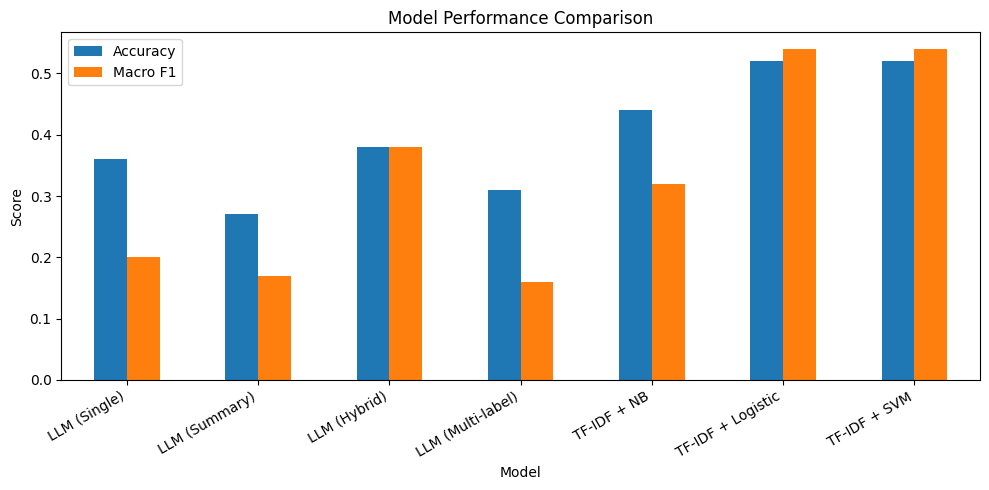

In [26]:
results = pd.DataFrame({
    "Model": [
        "LLM (Single)",
        "LLM (Summary)",
        "LLM (Hybrid)",
        "LLM (Multi-label)",
        "TF-IDF + NB",
        "TF-IDF + Logistic",
        "TF-IDF + SVM"
    ],
    "Accuracy": [0.36, 0.27, 0.38, 0.31, 0.44, 0.52, 0.52],
    "Macro F1": [0.20, 0.17, 0.38, 0.16, 0.32, 0.54, 0.54]
})

results.set_index("Model").plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


None of these LLM attempts beat out the traditional models however.

Further comparions between the best performing traditional model and the best performing LLM attempt are featured below by using confusion matrices to get more indepth analyis on a per genre basis.

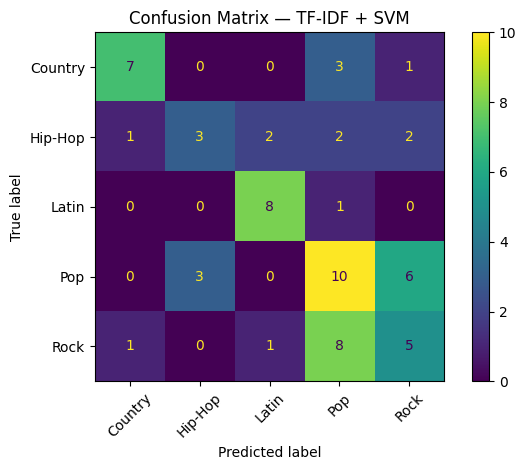

In [22]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    svm_preds,
    xticks_rotation=45
)

plt.title("Confusion Matrix — TF-IDF + SVM")
plt.tight_layout()
plt.show()


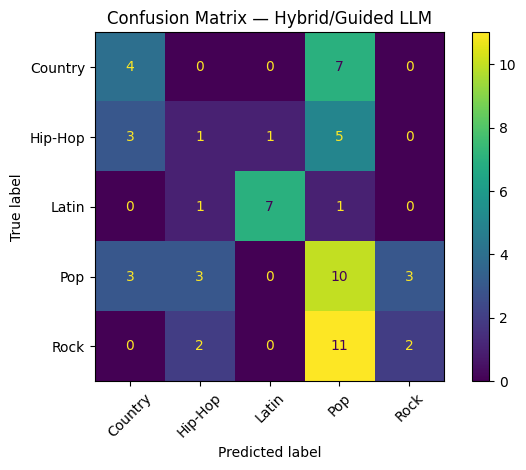

In [27]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    hybrid_preds,
    xticks_rotation=45
)



plt.title("Confusion Matrix — Hybrid/Guided LLM")
plt.tight_layout()
plt.show()

Below is a comaprison of the F1 score per genre of the Hybrid LLM attempt and the two linear models.

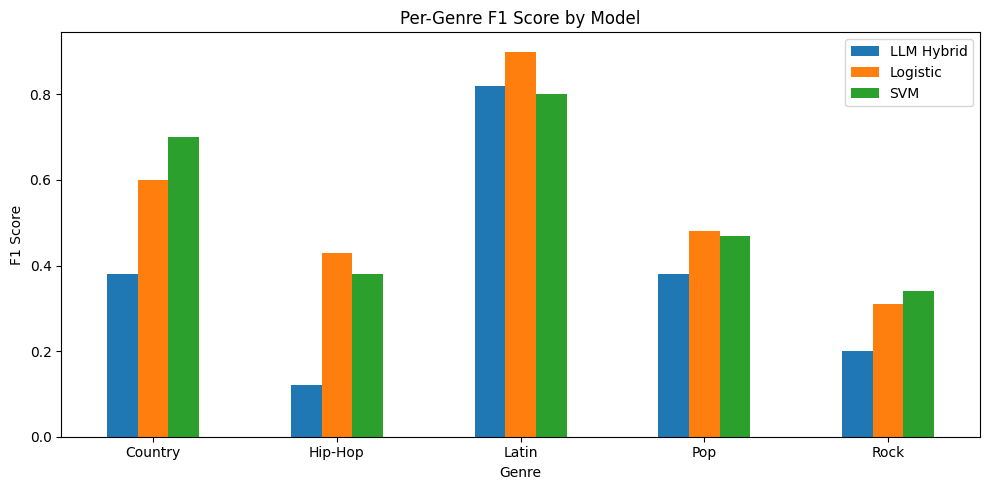

In [23]:
f1_data = pd.DataFrame({
    "Genre": ["Country", "Hip-Hop", "Latin", "Pop", "Rock"],
    "LLM Hybrid": [0.38, 0.12, 0.82, 0.38, 0.20],
    "Logistic": [0.60, 0.43, 0.90, 0.48, 0.31],
    "SVM": [0.70, 0.38, 0.80, 0.47, 0.34]
})

f1_data.set_index("Genre").plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("Per-Genre F1 Score by Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


For ease of reference, here is a chart showing the overall distribution of the songs per genre after tagging them with Last.FMs service.

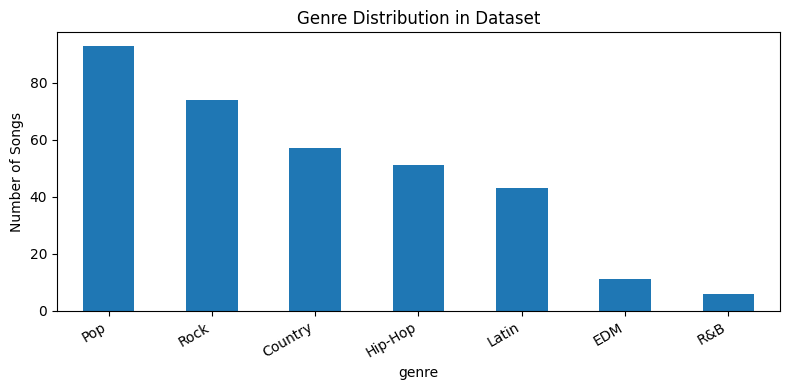

In [24]:
df["genre"].value_counts().plot(
    kind="bar",
    figsize=(8, 4)
)

plt.title("Genre Distribution in Dataset")
plt.ylabel("Number of Songs")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


## Final Conclusions

This project evaluated multiple approaches to song genre classification using lyrical content, including large language models (LLMs) and traditional supervised machine learning models built on TF-IDF features. Performance was assessed using accuracy and macro F1 score to account for class imbalance.

### Overall Model Performance

Across all experiments, traditional TF-IDF–based classifiers outperformed LLM-based approaches:

- **TF-IDF + Logistic Regression** and **TF-IDF + SVM** achieved the highest overall performance, each reaching:
  - **Accuracy ≈ 0.52**
  - **Macro F1 ≈ 0.54**
- Naive Bayes performed reasonably well but lagged behind the other classical models, particularly on minority genres.
- LLM-based classifiers showed lower accuracy and less consistent macro F1 scores, with the best LLM configuration (Hybrid approach) achieving:
  - **Accuracy = 0.38**
  - **Macro F1 = 0.38**

These results indicate that, for this dataset size and task formulation, feature-based supervised learning remains more reliable than zero-shot or prompt-based LLM classification.

### Genre-Level Insights

Analysis of per-genre F1 scores reveals several important patterns:

- **Latin** lyrics were consistently the easiest to classify across all models, achieving F1 scores above **0.80** for Logistic Regression, SVM, and the LLM Hybrid approach.
- **Country** and **Pop** showed moderate performance across models, benefiting from strong lexical signals and higher representation.
- **Hip-Hop** and **Rock** were more challenging, particularly for LLM-based methods, likely due to:
  - Greater stylistic diversity
  - Overlapping lyrical themes across genres
  - Less distinctive vocabulary in shorter excerpts

Notably, while LLMs struggled overall, the **Hybrid LLM approach performed competitively for Latin lyrics**, suggesting that LLMs may be effective for genres with strong linguistic or thematic markers.

### LLM vs Traditional Models

LLMs did not outperform classical models in this setting for several key reasons:

- Limited dataset size constrained LLM generalization
- Prompt-based classification is sensitive to wording and output variability
- Long lyrics required truncation or summarization, leading to information loss
- LLMs lacked explicit supervision compared to trained classifiers

However, LLMs demonstrated:
- Strong semantic understanding
- Reasonable performance in low-resource or ambiguous cases
- Potential as feature generators or assistive tools, rather than primary classifiers.

### Final Takeaway

The strongest conclusion from this study is that:

> Well-engineered classical models (TF-IDF + Logistic Regression or SVM) remain the most effective and reliable approach for lyric-based genre classification on small to medium datasets.

LLMs are better suited as complementary tools—for weak supervision, data augmentation, or semantic enrichment—rather than as standalone classifiers in this context.

Future work could explore:
- Fine-tuned transformer models on labeled lyric data
- Ensemble methods combining LLM outputs with supervised classifiers
- Multimodal approaches incorporating audio features alongside lyrics
